In [1]:
########## load packages
import os 
import sys
import random
sys.path.append("/home/project/11003054/changxu/Projects/SpaGNNs/Final_code/spagnns")

import pandas as pd 
import numpy as np 
import torch
import scanpy as sc
import anndata
import matplotlib.pyplot as plt

######## load dirac
from main import integrate_app
from utils import get_single_edge_index, get_multi_edge_index, lsi, _optimize_cluster, _priori_cluster, mclust_R
import episcanpy as epi
from torch_geometric.utils import to_dense_adj
from adj import graph

2024-10-07 12:26:42.619665: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 12:26:44.578123: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 12:26:44.831249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 12:26:45.405536: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 12:26:45.594850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 12:26:46.700173: I tensorflow/core/platform/cpu_feature_gu

[easydl] tensorflow not available!


In [2]:
def seed_torch(seed=1029):   
    random.seed(seed)    
    os.environ['PYTHONHASHSEED'] = str(seed)    
    np.random.seed(seed)    
    torch.manual_seed(seed)    
    torch.cuda.manual_seed(seed)    
    torch.cuda.manual_seed_all(seed) 
    # if you are using multi-GPU.    
    torch.backends.cudnn.benchmark = False    
    torch.backends.cudnn.deterministic = True

seed_torch(seed=0)

In [3]:
######### Define colors for spatial multi-omics domain
colormaps= ["#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "#A65628", "#FFFF33", "#F781BF", "#999999", 
            "#E5D8BD", "#B3CDE3", "#CCEBC5", "#FED9A6", "#FBB4AE", "#8DD3C7", "#BEBADA", "#80B1D3", "#B3DE69", "#FCCDE5", 
            "#BC80BD", "#FFED6F", "#8DA0CB", "#E78AC3", "#E5C494", "#CCCCCC", "#FB9A99", "#E31A1C", "#CAB2D6","#6A3D9A", "#B15928"]

In [4]:
data_path = "/home/project/11003054/changxu/Data/DBit_seq"
data_name = "0725"
methods = "Dirac"

In [5]:
adata_RNA = sc.read(os.path.join(data_path, f"{data_name}_RNA.h5ad"))
adata_Protein = sc.read(os.path.join(data_path, f"{data_name}_Protein.h5ad"))
adata_RNA.raw = adata_RNA
adata_Protein.raw = adata_Protein

In [6]:
adata_Protein[adata_RNA.obs_names]

View of AnnData object with n_obs × n_vars = 936 × 22
    obs: 'x', 'y', 'ground_truth'
    obsm: 'spatial'

In [7]:
######### Data processing
n_clusters = len(adata_RNA.obs["ground_truth"].unique())
adata_RNA.obs["Omics"] = data_name + "_mRNA"
adata_RNA.obs['Omics'] = adata_RNA.obs['Omics'].astype('category')
adata_Protein.obs["Omics"] = data_name + "_Protein"
adata_Protein.obs['Omics'] = adata_Protein.obs['Omics'].astype('category')

In [8]:
######### Data processing
sc.pp.filter_genes(adata_RNA, min_cells=3)
sc.pp.normalize_total(adata_RNA)
sc.pp.log1p(adata_RNA)
sc.pp.highly_variable_genes(adata_RNA, n_top_genes=3000, subset=True, flavor='seurat_v3')
sc.pp.scale(adata_RNA)
sc.tl.pca(adata_RNA, n_comps=40)

In [9]:
sc.pp.normalize_total(adata_Protein)
sc.pp.log1p(adata_Protein)
sc.pp.scale(adata_Protein)

In [98]:
# adj = graph(data = adata_RNA.obsm["spatial"],
# 					rad_cutoff = 150,
# 					k = 5,
# 					distType= "KDTree", ### "BallTree", "Radius", "kneighbors_graph",'KDTree'
# 					).main()["adj_norm"]

# row, col, edge_attr = adj.t().coo()
# edge_index_spatial = torch.stack([row, col], dim=0)

# edge_index_RNA = get_single_edge_index(np.concatenate((adata_Protein.X, adata_RNA.obsm['X_pca']),axis=1), n_neighbors=20, graph_methods="knn")
# edge_index_RNA = torch.LongTensor(list(edge_index_RNA)).T

In [99]:
# print(edge_index_spatial)
# print(edge_index_RNA )

In [100]:
# import torch

# # 先提取edge_index_spatial和edge_index_RNA的行和列
# edge_index_spatial_set = set(map(tuple, edge_index_spatial.T.tolist()))
# edge_index_RNA_set = set(map(tuple, edge_index_RNA.T.tolist()))

# # 取交集
# edge_index_intersection = edge_index_spatial_set & edge_index_RNA_set

# # 将结果转换回张量形式
# edge_index_intersection = torch.tensor(list(edge_index_intersection)).T

# # 输出交集的结果
# print(edge_index_intersection.shape)
# edge_index = edge_index_intersection
# print(edge_index.shape[1] / adata_RNA.shape[0])

In [101]:
# adj = graph(data = adata_RNA.obsm["spatial"],
# 					rad_cutoff = 150,
# 					k = 10,
# 					distType= "KDTree", ### "BallTree", "Radius", "kneighbors_graph",'KDTree'
# 					).main()["adj_norm"]

# row, col, edge_attr = adj.t().coo()
# edge_index_spatial = torch.stack([row, col], dim=0)


# edge_index_RNA = get_single_edge_index(np.concatenate((adata_Protein.X, adata_RNA.obsm['X_pca']),axis=1), n_neighbors=30, graph_methods="knn")
# edge_index_RNA = torch.LongTensor(list(edge_index_RNA)).T

# # np.concatenate((adata_Protein.X, adata_RNA.obsm['X_pca']),axis=1)

# # 先提取edge_index_spatial和edge_index_RNA的行和列
# edge_index_spatial_set = set(map(tuple, edge_index_spatial.T.tolist()))
# edge_index_RNA_set = set(map(tuple, edge_index_RNA.T.tolist()))

# # 取交集
# edge_index_intersection = edge_index_spatial_set & edge_index_RNA_set

# # 将结果转换回张量形式
# edge_index_intersection = torch.tensor(list(edge_index_intersection)).T

# # 输出交集的结果
# print(edge_index_intersection.shape)
# edge_index = edge_index_intersection
# print(edge_index.shape[1] / adata_RNA.shape[0])

In [102]:
# edge_index_RNA = get_single_edge_index(np.concatenate((adata_Protein.X, adata_RNA.obsm['X_pca']),axis=1), n_neighbors=30, graph_methods="knn")
# edge_index_spatial = get_single_edge_index(adata_Protein.obsm['spatial'].copy(), n_neighbors=15, graph_methods="knn")

# edge_set_RNA = set(map(tuple, edge_index_RNA))
# edge_set_spatial = set(map(tuple, edge_index_spatial))

# edge_intersection = edge_set_RNA & edge_set_spatial
# print(len(edge_intersection) / adata_RNA.shape[0])
# edge_index = torch.LongTensor(list(edge_intersection)).T

In [103]:
# edge_index = get_single_edge_index(adata_RNA.obsm['spatial'].copy(), n_neighbors = 8, graph_methods = "knn")
# print(len(edge_index)/adata_RNA.shape[0])
# edge_index = torch.LongTensor(edge_index).T

In [10]:
adj = graph(data = adata_RNA.obsm["spatial"],
					rad_cutoff = 1.5,
					k = 8,
					distType= "KDTree", ### "BallTree", "Radius", "kneighbors_graph",'KDTree'
					).main()["adj_norm"]

row, col, edge_attr = adj.t().coo()
edge_index = torch.stack([row, col], dim=0)

In [11]:
y = pd.Categorical(
            np.array(adata_RNA.obs["Omics"]),
            categories=np.unique(adata_RNA.obs["Omics"]),
        ).codes
save_path = os.path.join("/home/users/nus/changxu/scratch/section1/Results", f"{data_name}_{methods}")
if not os.path.exists(save_path):
	os.makedirs(save_path)

In [12]:
###### Training Dirac for spatial multi-omics
unsuper = integrate_app(save_path = save_path, use_gpu = True, subgraph = False)
samples = unsuper._get_data(dataset_list = [adata_RNA.obsm["X_pca"].copy(), adata_Protein.X.copy()],
							batch_list = [y, y],
							domain_list = [np.zeros(adata_RNA.shape[0]), np.ones(adata_Protein.shape[0])],
							edge_index = edge_index,
                            num_parts = 10,
                            num_workers = 1,)
models = unsuper._get_model(samples, 
						n_hiddens = 128,
        				n_outputs = 64,
        				opt_GNN = "GCN",
                           ) ### MF, FeaSt, ClusterGCN, SAGE, GAT)
data_z, combine_recon, now = unsuper._train_dirac_integrate(samples = samples,
							models = models,
							epochs = 500,
                            lamb = 5e-4, 
                            scale_loss = 0.025,
                            lr = 1e-3,
                            wd = 5e-2,)

Found 2 unique domains.


Project..: 100%|█| 500/500 [00:12<00:00, 40.36it/s, Loss=73.3, D


In [13]:
adata_RNA.obsm[f"{methods}_embed"] = data_z[: adata_RNA.shape[0], :]
adata_Protein.obsm[f"{methods}_embed"] = data_z[adata_RNA.shape[0] :, :]
adata_RNA.obsm["combine_recon"] = combine_recon
adata_Protein.obsm["combine_recon"] = combine_recon

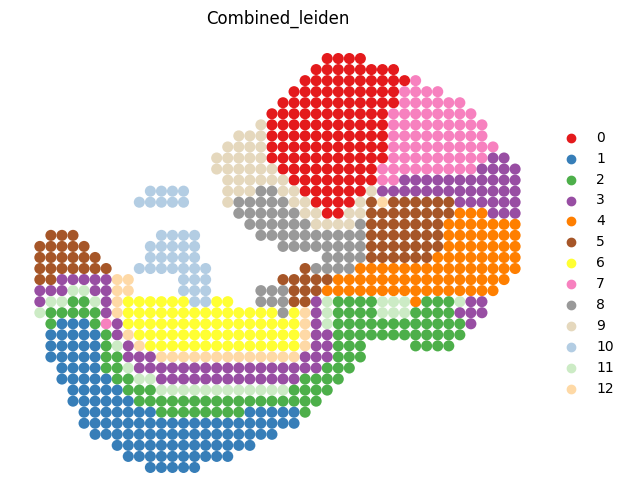

In [16]:
# adata_RNA = sc.read("/home/users/nus/changxu/scratch/section1/Results/0725_Dirac/0725_DIRAC_RNA_Final_V2.h5ad")
# fig, ax = plt.subplots(figsize=(8, 6))
# sc.pl.spatial(adata_RNA, color=["Combined_leiden"], palette = colormaps, frameon=False, spot_size=1, ax=ax)
# fig.savefig(os.path.join(save_path, f"{data_name}_{methods}_Combined_spatial_{now}.pdf"), bbox_inches='tight', dpi = 300)

####### Combined
sc.pp.neighbors(adata_RNA, use_rep='combine_recon')
res_RNA_ATAC = _priori_cluster(adata_RNA, eval_cluster_n = n_clusters)
sc.tl.leiden(adata_RNA, resolution = res_RNA_ATAC, key_added="Combined_leiden")
# mclust_R(adata=adata_RNA, num_cluster = n_clusters, used_obsm="combine_recon",key_added="Combined_mclust")
# sc.pl.spatial(adata_RNA, color=["Combined_mclust", "Combined_leiden", "ground_truth"], palette = colormaps, frameon=False, spot_size=1)
fig, ax = plt.subplots(figsize=(8, 6))
sc.pl.spatial(adata_RNA, color=["Combined_leiden"], palette = colormaps, frameon=False, spot_size=1, ax=ax)
fig.savefig(os.path.join(save_path, f"{data_name}_{methods}_Combined_spatial_{now}.pdf"), bbox_inches='tight', dpi = 300)

Best resolution:  0.3800000000000001


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


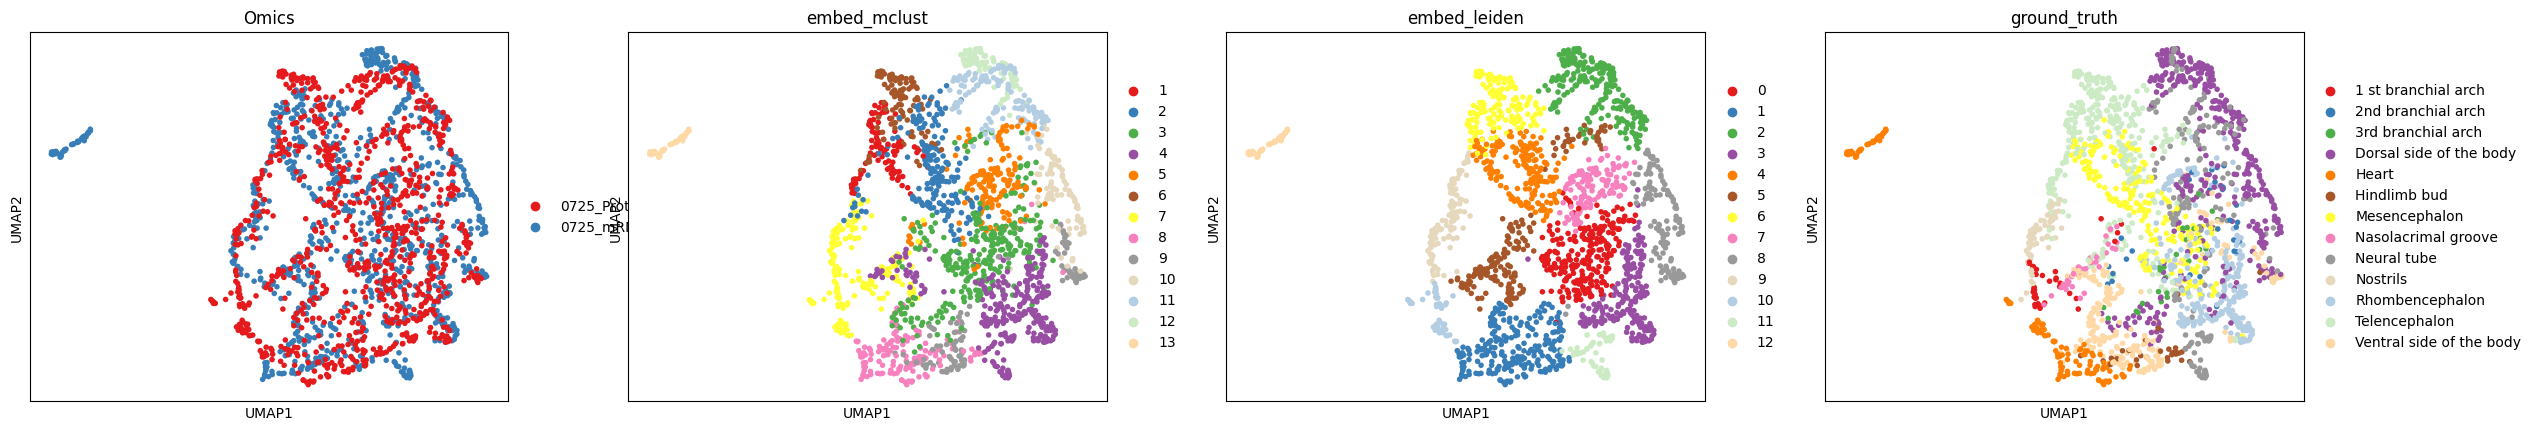

<Figure size 640x480 with 0 Axes>

In [17]:
adata = anndata.AnnData(data_z)
adata.obs = pd.concat([adata_RNA.obs, adata_Protein.obs])
adata.obsm[f"{methods}_embed"] = data_z
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
res_RNA_ATAC = _priori_cluster(adata, eval_cluster_n = n_clusters)
sc.tl.leiden(adata, resolution = res_RNA_ATAC, key_added="embed_leiden")
mclust_R(adata=adata, num_cluster = n_clusters, used_obsm=f"{methods}_embed", key_added="embed_mclust")
sc.pl.umap(adata, color=['Omics', "embed_mclust", "embed_leiden", "ground_truth"], palette = colormaps)
plt.savefig(os.path.join(save_path, f"{data_name}_{methods}_embed_umap_{now}.pdf"), bbox_inches='tight', dpi = 300)

In [18]:
methods = "DIRAC"
adata_RNA.write(os.path.join(save_path, f"{data_name}_{methods}_RNA_Final_{now}.h5ad"))
adata_Protein.write(os.path.join(save_path, f"{data_name}_{methods}_Protein_Final_{now}.h5ad"))

In [19]:
print(now)

20241007122815


In [386]:
######## cal omics mixing
(0.5805218173639230+0.828645646572113+0.9952498604030420)/3

0.8014724414463593

In [5]:
(0.7512547373771670+0.003148897885740170+0.47584301805047800)/3

0.41008221777112835

In [6]:
(0.0513981394469738+0.003148897885740170+0.10598598965112200)/3

0.053511008994611996

In [7]:
(0.8307048082351690+0.6327035537561860+0.7128846828390910)/3

0.7254310149434819

In [8]:
######## b
(0.798203959652939+0.39745932072401000+0.4631206635041540)/3

0.552927981293701

In [9]:
(0.6908222676788880+0.47577716782689100+0.3391761679977240)/3

0.5019252011678343

In [10]:
(0.2530509254147970+0.0513981394469738+0.10598598965112200)/3

0.13681168483763093

In [11]:
(0.4272800534963610+0.39228085395073500+0.1628298046204500)/3

0.32746357068918197

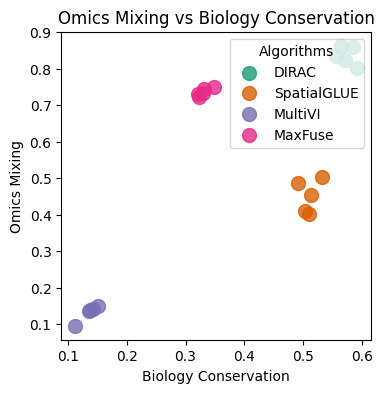

In [20]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Sample data for plotting
# omics_mixing = np.array([
#        [0.83498945, 0.8594751934, 0.8014724414463593, 0.863423424, 0.824523435],
#        [0.41003434, 0.45394324, 0.5039421, 0.4873453, 0.40234113],
#        [0.1362456, 0.09545135, 0.15034123, 0.1412351, 0.139473853],
#        [0.72343151, 0.7452451, 0.73414511, 0.73115123, 0.750241351]])

# biology_conservation = np.array([
#        [0.5552341, 0.583412341, 0.59134123, 0.563415657, 0.5714572854],
#        [0.50313451, 0.51309554, 0.531003415, 0.4913413, 0.51039410234],
#        [0.1368116, 0.1130481324, 0.151348193, 0.1423134, 0.13713983401],
#        [0.32352151, 0.331304850, 0.329869835, 0.320860435, 0.34910379134]])

# # Algorithms and colors
# algorithms = ['DIRAC', 'SpatialGLUE', 'MultiVI', 'MaxFuse']
# colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']

# # Create a single plot
# fig, ax = plt.subplots(figsize=(4, 4))

# # Scatter plot for each algorithm
# for k, alg in enumerate(algorithms):
#     ax.scatter(biology_conservation[k], omics_mixing[k], c=colors[k], label=alg, alpha=0.8, s=100)

# ax.set_title('Omics Mixing vs Biology Conservation')
# ax.set_xlabel('Biology Conservation')
# ax.set_ylabel('Omics Mixing')
# # ax.grid(True)

# # Add legend
# ax.legend(loc='upper right', title='Algorithms')

# # Save the figure as a PDF
# fig.savefig("/home/users/nus/changxu/scratch/section1/omics_mixing_vs_biology_conservation.pdf", format='pdf')

# # Show plot
# plt.show()

DIRAC - Omics Mixing: Mean = 0.8368, Variance = 0.0005
DIRAC - Biology Conservation: Mean = 0.5730, Variance = 0.0002
SpatialGLUE - Omics Mixing: Mean = 0.4515, Variance = 0.0016
SpatialGLUE - Biology Conservation: Mean = 0.5098, Variance = 0.0002
MultiVI - Omics Mixing: Mean = 0.1325, Variance = 0.0004
MultiVI - Biology Conservation: Mean = 0.1361, Variance = 0.0002
MaxFuse - Omics Mixing: Mean = 0.7368, Variance = 0.0001
MaxFuse - Biology Conservation: Mean = 0.3309, Variance = 0.0001
P-value (DIRAC vs SpatialGLUE on Biology Conservation): 0.0001
P-value (DIRAC vs MaxFuse on Omics Mixing): 0.0000


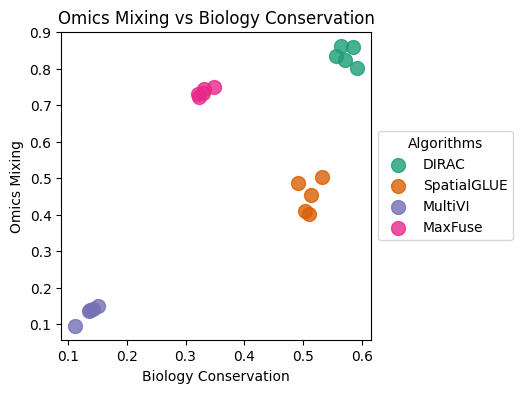

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Sample data for plotting
omics_mixing = np.array([
       [0.83498945, 0.8594751934, 0.8014724414463593, 0.863423424, 0.824523435],
       [0.41003434, 0.45394324, 0.5039421, 0.4873453, 0.40234113],
       [0.1362456, 0.09545135, 0.15034123, 0.1412351, 0.139473853],
       [0.72343151, 0.7452451, 0.73414511, 0.73115123, 0.750241351]])

biology_conservation = np.array([
       [0.5552341, 0.583412341, 0.59134123, 0.563415657, 0.5714572854],
       [0.50313451, 0.51309554, 0.531003415, 0.4913413, 0.51039410234],
       [0.1368116, 0.1130481324, 0.151348193, 0.1423134, 0.13713983401],
       [0.32352151, 0.331304850, 0.329869835, 0.320860435, 0.34910379134]])

# Algorithms and colors
algorithms = ['DIRAC', 'SpatialGLUE', 'MultiVI', 'MaxFuse']
colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']

# Step 1: Calculate mean and variance for each method in both omics_mixing and biology_conservation
omics_mean = np.mean(omics_mixing, axis=1)
omics_var = np.var(omics_mixing, axis=1)

biology_mean = np.mean(biology_conservation, axis=1)
biology_var = np.var(biology_conservation, axis=1)

for i, alg in enumerate(algorithms):
    print(f"{alg} - Omics Mixing: Mean = {omics_mean[i]:.4f}, Variance = {omics_var[i]:.4f}")
    print(f"{alg} - Biology Conservation: Mean = {biology_mean[i]:.4f}, Variance = {biology_var[i]:.4f}")

# Step 2: Calculate p-values using t-test
# DIRAC vs SpatialGLUE on biology conservation
biology_pvalue_dirac_vs_spatialglue = ttest_ind(biology_conservation[0], biology_conservation[1]).pvalue
# DIRAC vs MaxFuse on omics mixing
omics_pvalue_dirac_vs_maxfuse = ttest_ind(omics_mixing[0], omics_mixing[3]).pvalue

print(f"P-value (DIRAC vs SpatialGLUE on Biology Conservation): {biology_pvalue_dirac_vs_spatialglue:.4f}")
print(f"P-value (DIRAC vs MaxFuse on Omics Mixing): {omics_pvalue_dirac_vs_maxfuse:.4f}")

# Step 3: Create the plot and adjust the legend position to the right
fig, ax = plt.subplots(figsize=(4, 4))

# Scatter plot for each algorithm
for k, alg in enumerate(algorithms):
    ax.scatter(biology_conservation[k], omics_mixing[k], c=colors[k], label=alg, alpha=0.8, s=100)

ax.set_title('Omics Mixing vs Biology Conservation')
ax.set_xlabel('Biology Conservation')
ax.set_ylabel('Omics Mixing')

# Adjust legend position to the right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Algorithms')

# # Save the figure as a PDF
# fig.savefig("/home/users/nus/changxu/scratch/section1/omics_mixing_vs_biology_conservation.pdf", format='pdf')

# Show plot
plt.show()


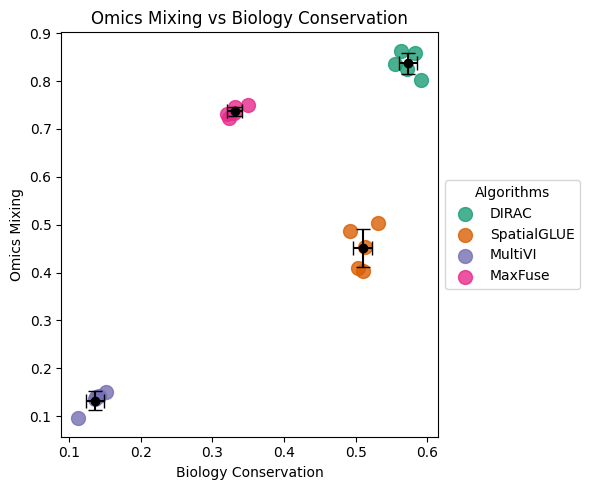

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Sample data for plotting
omics_mixing = np.array([
    [0.83498945, 0.8594751934, 0.8014724414463593, 0.863423424, 0.824523435],
    [0.41003434, 0.45394324, 0.5039421, 0.4873453, 0.40234113],
    [0.1362456, 0.09545135, 0.15034123, 0.1412351, 0.139473853],
    [0.72343151, 0.7452451, 0.73414511, 0.73115123, 0.750241351]
])

biology_conservation = np.array([
    [0.5552341, 0.583412341, 0.59134123, 0.563415657, 0.5714572854],
    [0.50313451, 0.51309554, 0.531003415, 0.4913413, 0.51039410234],
    [0.1368116, 0.1130481324, 0.151348193, 0.1423134, 0.13713983401],
    [0.32352151, 0.331304850, 0.329869835, 0.320860435, 0.34910379134]
])

# Algorithms and colors
algorithms = ['DIRAC', 'SpatialGLUE', 'MultiVI', 'MaxFuse']
colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']

# Step 1: Calculate mean and variance for each method in both omics_mixing and biology_conservation
omics_mean = np.mean(omics_mixing, axis=1)
omics_var = np.var(omics_mixing, axis=1)

biology_mean = np.mean(biology_conservation, axis=1)
biology_var = np.var(biology_conservation, axis=1)

# Step 2: Calculate p-values using t-test
# DIRAC vs SpatialGLUE on biology conservation
biology_pvalue_dirac_vs_spatialglue = ttest_ind(biology_conservation[0], biology_conservation[1]).pvalue
# DIRAC vs MaxFuse on omics mixing
omics_pvalue_dirac_vs_maxfuse = ttest_ind(omics_mixing[0], omics_mixing[3]).pvalue

# Step 3: Create the plot and adjust the legend position to the right
fig, ax = plt.subplots(figsize=(6, 5))

# Scatter plot for each algorithm with error bars for variance
for k, alg in enumerate(algorithms):
    ax.scatter(biology_conservation[k], omics_mixing[k], c=colors[k], label=alg, alpha=0.8, s=100)
    # Adding error bars for variance
    ax.errorbar(biology_mean[k], omics_mean[k], 
                xerr=np.sqrt(biology_var[k]), 
                yerr=np.sqrt(omics_var[k]), 
                fmt='o', 
                color='black', 
                capsize=5)

    # Annotate the means and variances
    # ax.annotate(f"μ={omics_mean[k]:.2f}\nσ²={omics_var[k]:.2f}", 
    #             (biology_mean[k], omics_mean[k]), 
    #             textcoords="offset points", 
    #             xytext=(0, 10), 
    #             ha='center', 
    #             fontsize=8)

ax.set_title('Omics Mixing vs Biology Conservation')
ax.set_xlabel('Biology Conservation')
ax.set_ylabel('Omics Mixing')

# Adjust legend position to the right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Algorithms')

# Show plot
plt.tight_layout()

# # Save the figure as a PDF
fig.savefig("/home/users/nus/changxu/scratch/section1/omics_mixing_vs_biology_conservation.pdf", format='pdf')
plt.show()


In [13]:
#### 计算two-sided t-test P
from scipy.stats import ttest_ind

# 两组样本数据
dirac_omics = [0.83498945, 0.8594751934, 0.8014724414463593, 0.863423424, 0.824523435]
maxfuse_omics= [0.72343151, 0.7452451, 0.73414511, 0.73115123, 0.750241351]

# 执行双侧t检验
t_stat, p_value = ttest_ind(dirac_omics, maxfuse_omics)
print(f"T-统计量: {t_stat}, P值: {p_value}")


T-统计量: 8.033820469547548, P值: 4.236155981833853e-05


In [12]:
#### 计算two-sided t-test P
from scipy.stats import ttest_ind

# 两组样本数据
dirac_bio = [0.5552341, 0.583412341, 0.59134123, 0.563415657, 0.5714572854]
maxfuse_bio= [0.50313451, 0.51309554, 0.531003415, 0.4913413, 0.51039410234]

# 执行双侧t检验
t_stat, p_value = ttest_ind(dirac_bio, maxfuse_bio)
print(f"T-统计量: {t_stat}, P值: {p_value}")

T-统计量: 6.8513826971751275, P值: 0.0001308057369819218


In [33]:
############ 单细胞的图
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel("/home/users/nus/changxu/scratch/section1/GLUE_metrics.xlsx")

df = df[df['dataset'].isin(['Chen-2019'])]
df = df[df['seed'].isin([0])]
df = df[df['method'].isin(["GLUE", "bindSC", "LIGER", "iNMF", "MMD_MA","UnionCom", "Pamona", "CCA_anchor"])]

In [34]:
df['method'].unique()

array(['CCA_anchor', 'GLUE', 'LIGER', 'bindSC', 'iNMF', 'MMD_MA',
       'Pamona', 'UnionCom'], dtype=object)

In [35]:
OM_matrix = []
BC_matrix = []
for m in ["GLUE", "bindSC", "LIGER", "iNMF", "CCA_anchor", "MMD_MA","UnionCom", "Pamona"]:
    current_df = df[df['method'].isin([m])]
    current_OM = current_df[['seurat_alignment_score', 'avg_silhouette_width', 'graph_connectivity']].mean(axis=1, skipna=True).mean()
    current_BC = current_df[['avg_silhouette_width_batch', 'mean_average_precision', 'neighbor_conservation']].mean(axis=1, skipna=True).mean()
    OM_matrix.append(current_OM)
    BC_matrix.append(current_BC)

OM_matrix = np.array(OM_matrix)
BC_matrix = np.array(BC_matrix)

print("Omics Mixing Matrix (OM):")
print(OM_matrix)
print("\nBiology Conservation Matrix (BC):")
print(BC_matrix)

Omics Mixing Matrix (OM):
[0.78299155 0.7233912  0.71942883 0.6949188  0.74947912 0.40671794
 0.34373605 0.57898798]

Biology Conservation Matrix (BC):
[0.65863334 0.54977929 0.4771649  0.46566849 0.50760745 0.38570252
 0.40193106 0.38699418]


In [36]:
###### BC DIRAC
(0.8761982221455350+0.6110268263469660+0.624183199679574)/3

0.7038027493906918

In [37]:
###### OB DIRAC
(0.8890110765924270+0.9396486841121320+0.9646516233235060)/3

0.9311037946760217

In [38]:
###### BC MultiVI
(0.5716835111379620+0.8816324044085480+0.30610263840736)/3

0.5864728513179567

In [39]:
###### OB MultiVI
(0.9371406022112320+0.9224315309524540+0.9026340458690580)/3

0.9207353930109147

In [40]:
OM_matrix

array([0.78299155, 0.7233912 , 0.71942883, 0.6949188 , 0.74947912,
       0.40671794, 0.34373605, 0.57898798])

In [41]:
BC_matrix

array([0.65863334, 0.54977929, 0.4771649 , 0.46566849, 0.50760745,
       0.38570252, 0.40193106, 0.38699418])

In [42]:
omics_mixing = np.array([0.804037946760217, 0.8007353930109147, 0.78299155, 0.7233912 , 0.71942883, 0.6949188 , 0.74947912,
                           0.40671794, 0.34373605, 0.57898798])

In [43]:
biology_conservation = np.array([0.7038027493906918, 0.5864728513179567, 0.65863334, 0.54977929, 0.4771649 , 0.46566849, 0.50760745,
                        0.38570252, 0.40193106, 0.38699418])

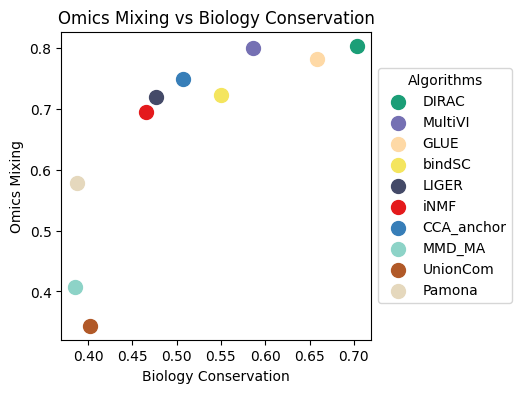

In [44]:

# Algorithms and colors
algorithms = ['DIRAC', 'MultiVI', "GLUE", "bindSC", "LIGER", "iNMF", "CCA_anchor", "MMD_MA","UnionCom", "Pamona"]
colors = ['#1b9e77', "#7570B3", "#FED9A6", '#F4E55E', '#444A68', "#E41A1C","#377EB8", "#8DD3C7","#B15928","#E5D8BD"]

# Create a single plot
fig, ax = plt.subplots(figsize=(4, 4))

# Scatter plot for each algorithm
for k, alg in enumerate(algorithms):
    ax.scatter(biology_conservation[k], omics_mixing[k], c=colors[k], label=alg, alpha=1, s=100)

ax.set_title('Omics Mixing vs Biology Conservation')
ax.set_xlabel('Biology Conservation')
ax.set_ylabel('Omics Mixing')
# ax.grid(True)

# Adjust legend position to the right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Algorithms')

# Save the figure as a PDF
fig.savefig("/home/users/nus/changxu/scratch/section1/omics_mixing_vs_biology_conservation_single_cell.pdf", format='pdf')

# Show plot
plt.show()

In [54]:
############ 单细胞的图
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel("/home/users/nus/changxu/scratch/section1/GLUE_metrics.xlsx")

df = df[df['dataset'].isin(['10x-Multiome-Pbmc10k'])]
df = df[df['seed'].isin([0])]
df = df[df['method'].isin(["GLUE", "bindSC", "LIGER", "iNMF", "MMD_MA","UnionCom", "Pamona", "CCA_anchor"])]

In [55]:
OM_matrix = []
BC_matrix = []
for m in ["GLUE", "bindSC", "LIGER", "iNMF", "CCA_anchor", "MMD_MA","UnionCom", "Pamona"]:
    current_df = df[df['method'].isin([m])]
    current_OM = current_df[['seurat_alignment_score', 'avg_silhouette_width', 'graph_connectivity']].mean(axis=1, skipna=True).mean()
    current_BC = current_df[['avg_silhouette_width_batch', 'mean_average_precision', 'neighbor_conservation']].mean(axis=1, skipna=True).mean()
    OM_matrix.append(current_OM)
    BC_matrix.append(current_BC)

OM_matrix = np.array(OM_matrix)
BC_matrix = np.array(BC_matrix)

print("Omics Mixing Matrix (OM):")
print(OM_matrix)
print("\nBiology Conservation Matrix (BC):")
print(BC_matrix)

Omics Mixing Matrix (OM):
[0.83652163 0.8069943  0.73123024 0.76645089 0.84931559 0.40776693
 0.43027918 0.59868067]

Biology Conservation Matrix (BC):
[0.69783562 0.65339562 0.55055399 0.56368238 0.59594102 0.37295933
 0.47062952 0.45741224]


In [56]:
###### BC DIRAC
print((0.87020248524525+0.6293813413417+0.6318394184141)/3)
###### OB DIRAC
print((0.8890110765924270+0.9396486841121320+0.9646516233235060)/3)

0.71047441500035
0.9311037946760217


In [57]:
###### BC MultiVI
print((0.5716835111379620+0.8816324044085480+0.30610263840736)/3)
###### OB MultiVI
print((0.9371406022112320+0.9224315309524540+0.9326340458690580)/3)

0.5864728513179567
0.9307353930109147


In [58]:
omics_mixing = np.array([0.9311037946760217, 0.9307353930109147, 0.83652163, 0.8069943,  0.73123024, 0.76645089, 0.84931559, 0.40776693,
                         0.43027918, 0.59868067])

In [59]:
biology_conservation = np.array([0.71047441500035, 0.5864728513179567, 0.69783562, 0.65339562, 0.55055399, 0.56368238, 0.59594102, 0.37295933,
                         0.47062952, 0.45741224])

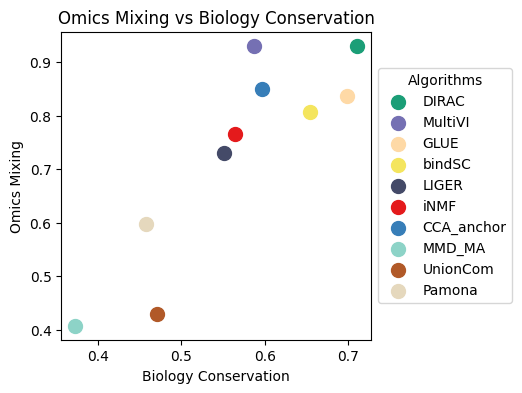

In [60]:
# Algorithms and colors
algorithms = ['DIRAC', 'MultiVI', "GLUE", "bindSC", "LIGER", "iNMF", "CCA_anchor", "MMD_MA","UnionCom", "Pamona"]
colors = ['#1b9e77', "#7570B3", "#FED9A6", '#F4E55E', '#444A68', "#E41A1C","#377EB8", "#8DD3C7","#B15928","#E5D8BD"]

# Create a single plot
fig, ax = plt.subplots(figsize=(4, 4))

# Scatter plot for each algorithm
for k, alg in enumerate(algorithms):
    ax.scatter(biology_conservation[k], omics_mixing[k], c=colors[k], label=alg, alpha=1, s=100)

ax.set_title('Omics Mixing vs Biology Conservation')
ax.set_xlabel('Biology Conservation')
ax.set_ylabel('Omics Mixing')
# ax.grid(True)

# Adjust legend position to the right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Algorithms')

# Save the figure as a PDF
fig.savefig("/home/users/nus/changxu/scratch/section1/omics_mixing_vs_biology_conservation_single_cell_10X_multiome.pdf", format='pdf')

# Show plot
plt.show()

<Figure size 1000x600 with 0 Axes>

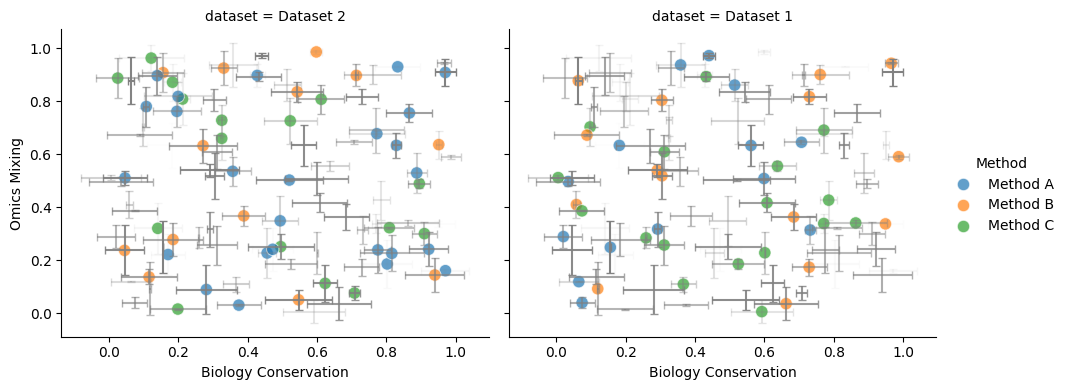

In [203]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Simulate some data
np.random.seed(42)

# Create a DataFrame to mimic biology conservation and omics mixing data
data = {
    'bio': np.random.rand(100),
    'int': np.random.rand(100),
    'bio_sd': np.random.rand(100) * 0.1,  # Standard deviation for biology conservation
    'int_sd': np.random.rand(100) * 0.1,  # Standard deviation for omics mixing
    'method': np.random.choice(['Method A', 'Method B', 'Method C'], 100),  # Different methods
    'dataset': np.random.choice(['Dataset 1', 'Dataset 2'], 100),  # Different datasets
    'alpha': np.random.rand(100)  # Transparency for each point
}

df = pd.DataFrame(data)

# Set up the plot size
plt.figure(figsize=(10, 6))

# Use Seaborn's FacetGrid to create facets based on the dataset column
g = sns.FacetGrid(df, col='dataset', height=4, aspect=1.2)

# Plot data with error bars and transparency
g.map_dataframe(sns.scatterplot, 'bio', 'int', hue='method', alpha=0.7, s=80)

# Add horizontal and vertical error bars
for ax in g.axes.flatten():
    for _, row in df.iterrows():
        ax.errorbar(row['bio'], row['int'],
                    xerr=row['bio_sd'], yerr=row['int_sd'],
                    fmt='none', ecolor='gray', alpha=row['alpha'], capsize=3)

# Customize the plot
g.set_axis_labels("Biology Conservation", "Omics Mixing")
g.add_legend(title="Method")

# Display the plot
plt.show()


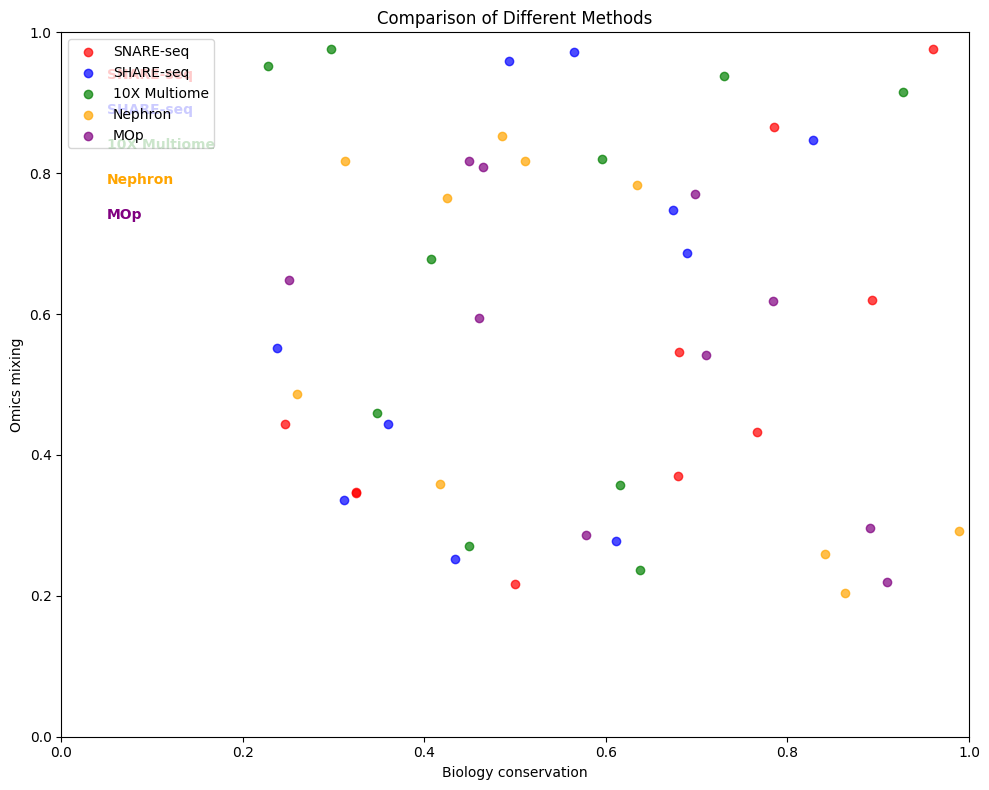

In [205]:
import matplotlib.pyplot as plt
import numpy as np

# Create sample data
np.random.seed(42)
methods = ['SNARE-seq', 'SHARE-seq', '10X Multiome', 'Nephron', 'MOp']
colors = ['red', 'blue', 'green', 'orange', 'purple']
n_points = 10

data = []
for method in methods:
    x = np.random.uniform(0.2, 1, n_points)
    y = np.random.uniform(0.2, 1, n_points)
    data.append((method, x, y))

# Create the plot
plt.figure(figsize=(10, 8))

for (method, x, y), color in zip(data, colors):
    plt.scatter(x, y, c=color, label=method, alpha=0.7)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Biology conservation')
plt.ylabel('Omics mixing')
plt.title('Comparison of Different Methods')
plt.legend()

# Add text labels for each method
for i, method in enumerate(methods):
    plt.annotate(method, (0.05, 0.95 - i*0.05), xycoords='axes fraction', 
                 fontsize=10, ha='left', va='top',
                 color=colors[i], weight='bold')

plt.tight_layout()
plt.show()

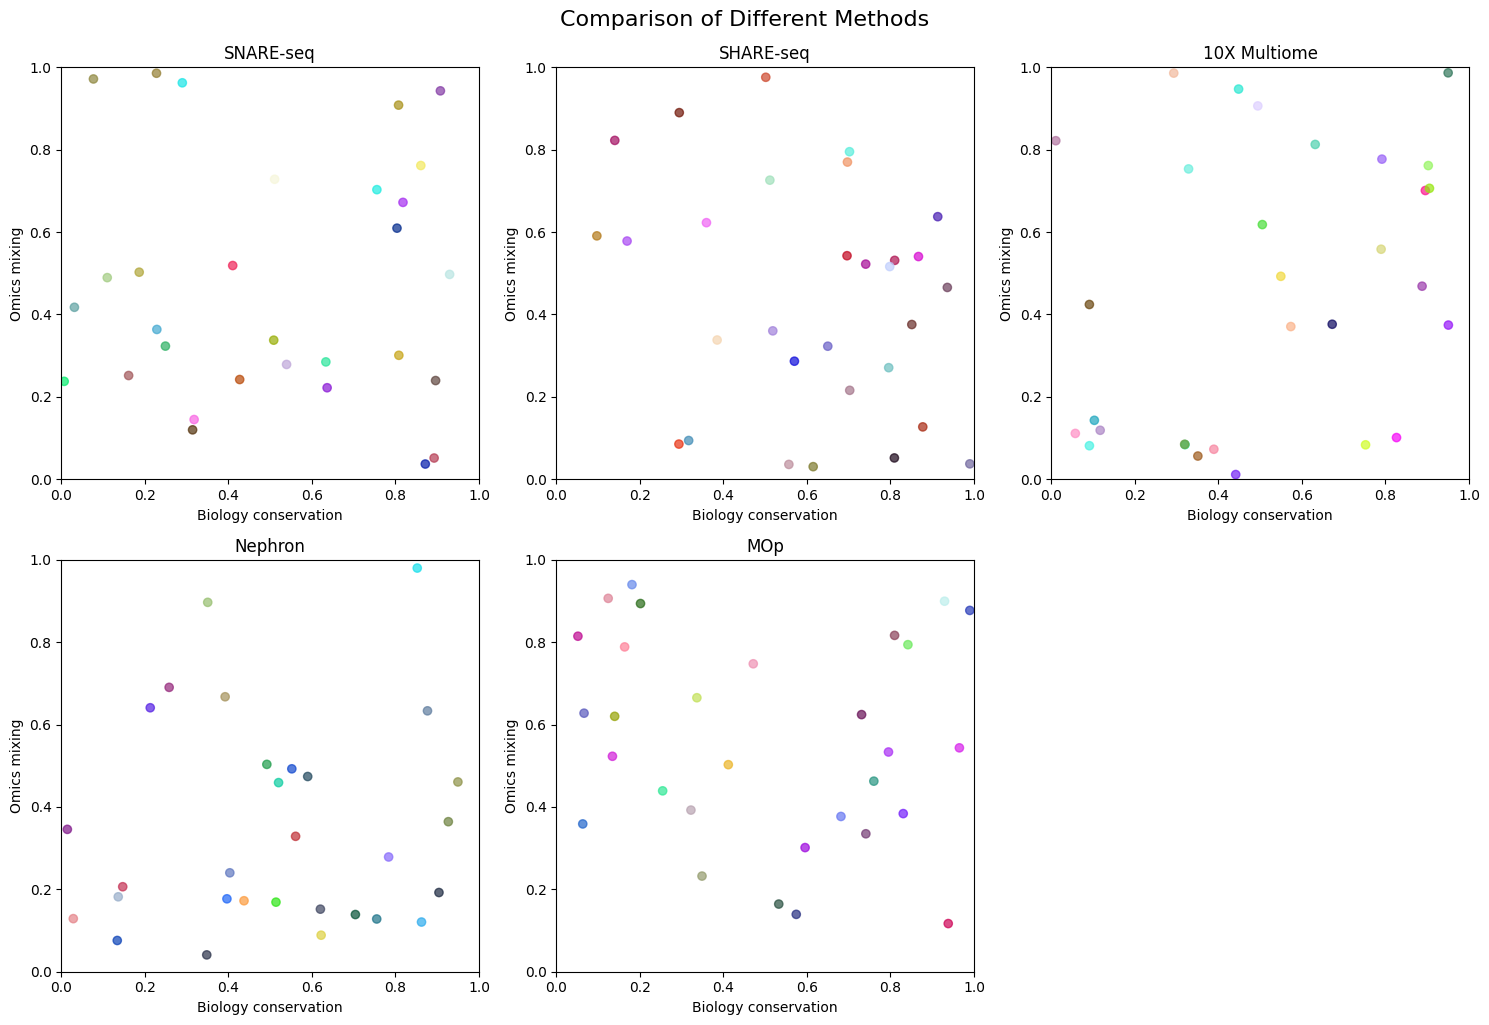

In [206]:
import matplotlib.pyplot as plt
import numpy as np

# Define methods
methods = ['SNARE-seq', 'SHARE-seq', '10X Multiome', 'Nephron', 'MOp']

# Create the plot
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, method in enumerate(methods):
    # Generate random data for each method
    n_points = 30
    x = np.random.uniform(0, 1, n_points)
    y = np.random.uniform(0, 1, n_points)
    
    # Generate random colors for each point
    colors = np.random.rand(n_points, 3)
    
    # Create scatter plot
    axs[i].scatter(x, y, c=colors, alpha=0.7)
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, 1)
    axs[i].set_title(method)
    axs[i].set_xlabel('Biology conservation')
    axs[i].set_ylabel('Omics mixing')

# Remove the last (empty) subplot
fig.delaxes(axs[5])

# Adjust the layout and add a main title
plt.tight_layout()
fig.suptitle('Comparison of Different Methods', fontsize=16, y=1.02)

plt.show()

In [90]:
############ 单细胞的图
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel("/home/users/nus/changxu/scratch/section1/GLUE_metrics.xlsx")

# df = df[df['dataset'].isin(['Chen-2019'])]
# df = df[df['seed'].isin([0])]
# df = df[df['method'].isin(["GLUE", "bindSC", "LIGER", "iNMF", "MMD_MA","UnionCom", "Pamona", "CCA_anchor"])]

In [92]:
df['dataset'].unique()

array(['10x-Multiome-Pbmc10k', 'Chen-2019', 'Ma-2020', 'Muto-2021',
       'Yao-2021'], dtype=object)